# Drive Mount

In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
import os
os.chdir("gdrive/Shared drives/Large Scale Analytics")


In [0]:
%matplotlib inline
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, ImageColorGenerator
from nltk import FreqDist
#split Data
from sklearn.model_selection import train_test_split
#Spacy for "# Tokenization for the Clened Data"
import spacy
from tqdm import tqdm
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])
#CSR Matrix
from sklearn.feature_extraction.text import TfidfVectorizer
#pickel dump
import pickle
#models
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
#keras
import itertools
import os

import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


# Dataset read

In [7]:
data = pd.read_csv("happydb/cleaned_hm.csv")
data.head(2)
data = data[["cleaned_hm","predicted_category"]]
# Confirm that we have a balanced dataset

data['predicted_category'].value_counts()

affection           34168
achievement         33993
enjoy_the_moment    11144
bonding             10727
leisure              7458
nature               1843
exercise             1202
Name: predicted_category, dtype: int64

In [8]:

# Split data into train and test
train_size = int(len(data) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))


Train size: 80428
Test size: 20107


In [0]:
train_posts = data['cleaned_hm'][:train_size]
train_tags = data['predicted_category'][:train_size]

test_posts = data['cleaned_hm'][train_size:]
test_tags = data['predicted_category'][train_size:]


In [0]:
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

# Model : Deep Neural Network

In [0]:
tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

In [0]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [0]:
# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [14]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_test shape: (20107, 1000)
y_train shape: (80428, 7)
y_test shape: (20107, 7)


In [15]:
# Build the model
batch_size = 32
epochs = 25
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




# Running Model

In [16]:
# model.fit trains the model
# The validation_split param tells Keras what % of our training data should be used in the validation set
# You can see the validation loss decreasing slowly when you run this
# Because val_loss is no longer decreasing we stop training to prevent overfitting
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 72385 samples, validate on 8043 samples
Epoch 1/25





72385/72385 [==============================] - 16s 219us/step - loss: 0.4488 - acc: 0.8463 - val_loss: 0.3332 - val_acc: 0.8814
Epoch 2/25
72385/72385 [==============================] - 13s 176us/step - loss: 0.2999 - acc: 0.8924 - val_loss: 0.3294 - val_acc: 0.8795
Epoch 3/25
72385/72385 [==============================] - 13s 183us/step - loss: 0.2608 - acc: 0.9066 - val_loss: 0.3178 - val_acc: 0.8839
Epoch 4/25
72385/72385 [==============================] - 13s 175us/step - loss: 0.2306 - acc: 0.9176 - val_loss: 0.3229 - val_acc: 0.8825
Epoch 5/25
72385/72385 [==============================] - 13s 174us/step - loss: 0.2018 - acc: 0.9276 - val_loss: 0.3265 - val_acc: 0.8852
Epoch 6/25
72385/72385 [==============================] - 13s 176us/step - loss: 0.1778 - acc: 0.9377 - val_loss: 0.3419 - val_acc: 0.8810
Epoch 7/25
7238

# Roc Curve

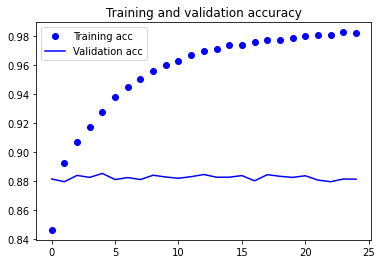

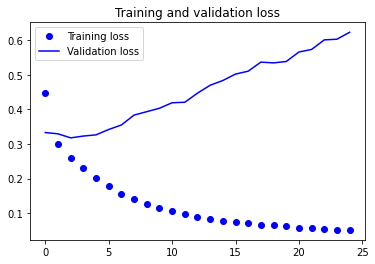

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Validation Evaluation

In [24]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

20107/20107 [==============================] - 1s 55us/step
Test score: 0.6634540015677535
Test accuracy: 0.8734768986043875


In [25]:
text_labels = encoder.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_posts.iloc[i][:50], "...")
    print('Actual label:' + test_tags.iloc[i])
    print("Predicted label: " + predicted_label + "\n")

I made the most delicious meal for my significant  ...
Actual label:affection
Predicted label: affection

I spent time with colleagues at a work conference  ...
Actual label:bonding
Predicted label: bonding

I donated a bunch of old books I had to the local  ...
Actual label:enjoy_the_moment
Predicted label: enjoy_the_moment

I attended the wedding of my cousin. ...
Actual label:affection
Predicted label: affection

I found $50 in my winter jacket ...
Actual label:achievement
Predicted label: achievement

I Went to the Dollar Store earlier and was able to ...
Actual label:achievement
Predicted label: achievement

I got a big lead at work and was recognized for it ...
Actual label:achievement
Predicted label: achievement

Watch a movie of terror at home, eating cotufas an ...
Actual label:leisure
Predicted label: leisure

I got a really nice desert last night and a fidget ...
Actual label:achievement
Predicted label: achievement

last month i went a tour to banglore, and i enjoye ...
Ac

# Function: Plot ROC(Receiver operating characteristic) curve

In [0]:
#y_test_num = Ytest
# pred_num = cv_test , x_test
def print_roc(y_test_num, pred_num,clsType):  
  clsType = "Receiver operating characteristic: "+clsType
  fpr, tpr, thresholds = roc_curve(yTestNum, [x for x in pred_num], pos_label=1) #nb_predNum
  print("fpr",fpr)
  print("tpr",tpr)
  print("thresholds",thresholds)
  # fpr, tpr, thresholds = roc_curve(yTestNum, [x[1] for x in pred_num], pos_label=1) #nb_predNum
  roc_auc = auc(fpr, tpr)
  print('roc_auc: ', roc_auc)
  plt.plot(fpr, tpr, lw=1, alpha=0.9, label='ROC fold (AUC = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(clsType)
  plt.legend(loc="lower right")
  plt.show()

# from sklearn.metrics import roc_auc_score
# roc_auc_score(y_test,y_pred)

# def print_roc(y_test, y_pred, average="macro"):
#   lb = LabelBinarizer()
#   lb.fit(y_test)
#   roc_curve
#   y_test = lb.transform(y_test)
#   y_pred = lb.transform(y_pred)
#   fpr, tpr, thresholds = roc_curve(yTestNum, pred_num, pos_label=1)
#   return roc_auc_score(y_test, y_pred, average=average)


# Confusion Matrix

In [0]:
y_softmax = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [0]:
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap, alpha= 1,)
    plt.title(title, fontsize=25)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=20, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.4f'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)



[[5758  158   39  313   16  127   19]
 [ 191 6012   78   93    4   35   17]
 [  71   65 1847   28    1    7    0]
 [ 482   77   43 2019    2   98   20]
 [  42    5    2   15  213    6    5]
 [ 158   26    9  154    4 1443    9]
 [  67   11    0   31    0   16  271]]


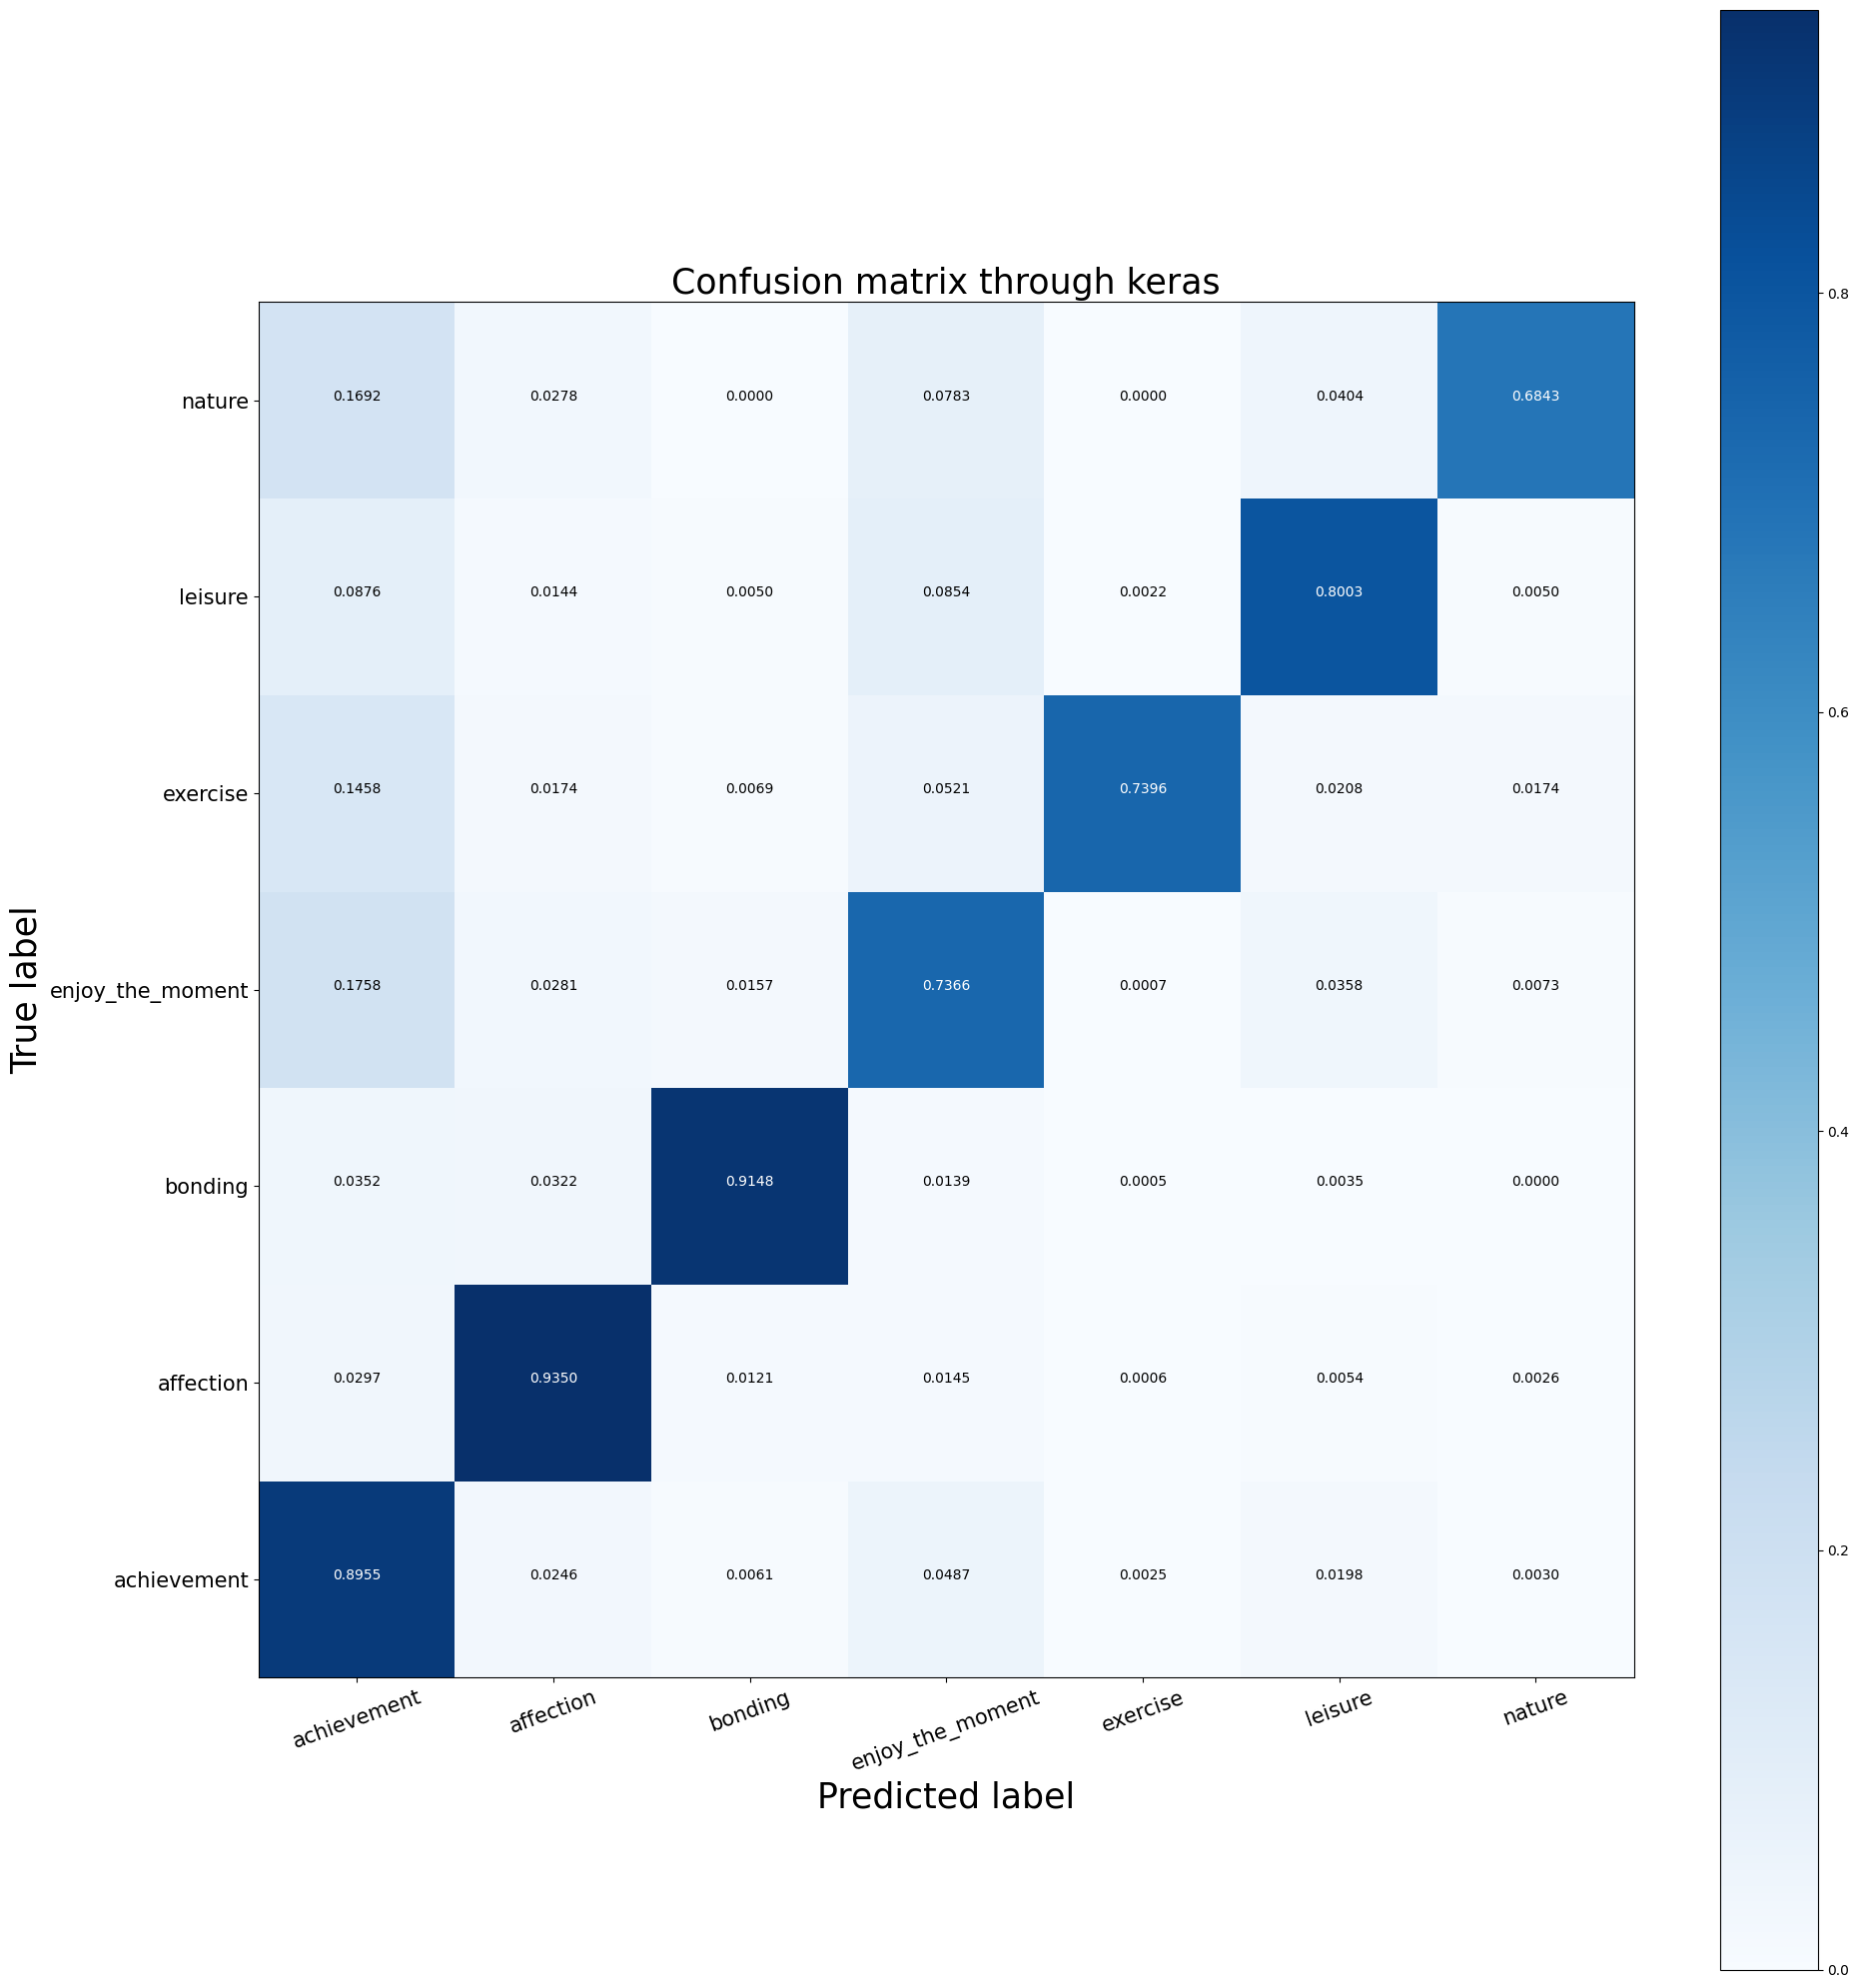

In [41]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
print(cnf_matrix)


import matplotlib.pyplot as plt
%matplotlib inline  

plt.figure(figsize=(20,20),dpi=100,frameon=False)
plt.ylim(-0.5,10-3.5)
# plt.xlim(-0.5)
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix through keras")
# plt.savefig("test.png",bbox_inches='tight')
plt.tight_layout()
plt.savefig("out.png")
plt.show()

# fig = plt.figure(figsize=(20,20))
# ax = fig.add_subplot(221)
# cax = ax.matshow(cnf_matrix)
# # ax.plot
# cax = plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
# plt.title('Confusion matrix of the classifier')
# fig.colorbar(cax)
# ax.set_xticklabels([''] + labels)
# ax.set_yticklabels([''] + labels)
# ax.set(classes=text_labels)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()



In [34]:
# pip install --upgrade matplotlib
pip install matplotlib==3.2.0rc1